<a href="https://colab.research.google.com/github/abellizzistudent/CST383_Project/blob/main/SAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Are Pitbulls one of the most problematic dog Breeds?



> by: Anna Bellizzi & Nicole George

---





In [6]:
!pip install pyreadstat
#FOR PERFPLOT CELL
!pip install perfplot
#!wget "https://cdn.pixabay.com/photo/2021/02/12/02/01/rosebud-6006985_1280.jpg"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import pyreadstat
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import matplotlib.pyplot as plt
import tarfile
import perfplot
import cv2
from sklearn.linear_model import LinearRegression
from scipy import stats
#for normalization
from sklearn import preprocessing


# allow output to span multiple output lines in the console
pd.set_option('display.max_columns', 500)

# switch to seaborn default stylistic parameters
# see the useful https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set()
sns.set_context('paper') # 'talk' for slightly larger

# change default plot size
rcParams['figure.figsize'] = 9,7

In [9]:
from google.colab import drive
drive.mount('/content/drive')
# /content/drive/Shareddrives/Data Science Project/DogBiteData/ny-dog-bites-2015-2021-CLEAN.csv
#dog bite data

#/content/drive/Shareddrives/Data Science Project/DogBiteData/sf-raw-data-dog-bites-2014-2018-CLEAN.csv
#sf raw dog bite data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#DATA aquisition and cleanup

In [10]:
#WHEN PROJECT IS RUN IN WEB/COLAB/DOWNLOAD OR BROWSER BY ANNA OR NICLE< RUN THIS
#Read in San Francisco Dataset
df_sf = pd.read_csv("/content/drive/Shareddrives/Data Science Project/DogBiteData/sf-raw-data-dog-bites-2014-2018-CLEAN.csv")

#Read in New York Dataset
df_ny = pd.read_csv("/content/drive/Shareddrives/Data Science Project/DogBiteData/ny-dog-bites-2015-2021-CLEAN.csv")

#Read in merged dataset, San Francisco and New York combined CSV
df_md = pd.read_csv("/content/drive/Shareddrives/Data Science Project/DogBiteData/merged-bite-data-CLEAN.csv")

#Read in Breeds Enriched Dataset
df_be = pd.read_csv("/content/drive/Shareddrives/Data Science Project/DogBiteData/dog breeds_enriched_20210503 - dog breeds_enriched_20210503-2.csv")

In [ ]:
#WHEN PROJECT IS RUN IN GITHUB RUN THIS
#Read in San Francisco Dataset
df_sf = pd.read_csv("/data/sf-raw-data-dog-bites-2014-2018-CLEAN.csv")

#Read in New York Dataset
df_ny = pd.read_csv("/data/ny-dog-bites-2015-2021-CLEAN.csv")

#Read in merged dataset, San Francisco and New York combined CSV
df_md = pd.read_csv("/data/DogBiteData/merged-bite-data-CLEAN.csv")

#Read in Breeds Enriched Dataset
df_be = pd.read_csv("/data/dog breeds_enriched_20210503 - dog breeds_enriched_20210503-2.csv")

Stanford Dogs Dataset Images of Dog Breeds

In [11]:
#Since this is a tarfile I am having trouble opening it, it was only going to be used for aestetic purposes. 
#I will continue working on this before the project is due.
#df_st = pd.read_csv('/lists.tar', compression='gzip', header=0, sep=' ', quotechar='"', error_bad_lines=False)
#OPEN TAR WITH WINZIP
#import tarfile
#tar = tarfile.open("/content/drive/Shareddrives/Data Science Project/DogBiteData/images.tar", "r")
#tar.extractall()


After reading in the data files, we need to do some merging and numeric value mapping.<br>
Most of the data is an object (string) and we need the columns converted to float64 or int64 to make analysis more straightforward.<br>
1. Duplicate the object columns; we want to retain the string values that correspond to the new numeric values/columns we are generating
2. Create the dictionary "file" which maps each unique string object in breed_group_S to a numeric value.
3. Traverse the dataframe and write values on key matches from the dictionary.
4. Repeat for dataset and gender columns.
<br><br> *Because we use this approach, we could not map NaN to NaN using the dictionary. Any values that would map as NaN were mapped as -1. This leaves us with columns reporting zero NaN values.*


In [12]:
"""
Compare breed names used in df_md to those in df_be so when we map breed_group
strings, they all get a numerical value. Some had to be corrected to match, for
example 'PIT BULL' and 'PITTBULL' need to be coded the same, so breed_group
strings in df_be were modified to match those in the larger dataset.
"""

#sfBreeds = pd.Series(df_sf['breed_group'])
#nyBreeds = pd.Series(df_ny['breed_group'])
breeds = pd.Series(df_be['breed_group'])
df_breeds = pd.Series(df_md['breed_group'])

ser = pd.Series(dtype='object')
#ser = ser.append(sfBreeds.str.lower())
#ser = ser.append(nyBreeds.str.lower())
ser = ser.append(breeds.str.upper())
ser = ser.append(df_breeds.str.upper())
#print(ser.unique())

In [13]:
#Code modified from source example at https://www.geeksforgeeks.org/replacing-strings-with-numbers-in-python-for-data-analysis/

#Create a duplicate so we retain the string vlaues in another col:

df_md['breed_group_S'] = df_md.loc[:, 'breed_group']
df_md['gender_S'] = df_md.loc[:, 'gender']
df_md['dataset_S'] = df_md.loc[:, 'dataset']

#Duplicate breed_group_S values into height, weight, lifespan so mapping of those values can occur
df_md['average height'] = df_md.loc[:, 'breed_group_S']
df_md['average_weight'] = df_md.loc[:, 'breed_group_S']

#add lifespan column and populate with breed_group_S so mapping of those values can occur
df_md['lifespan'] = df_md.loc[:, 'breed_group_S']

# NUMERICALLY CODE breed_group:
# creating a dict file 

breed = {'AFFENPINSCHER': 1,'AFGHAN HOUND': 2,'AIDI': 3,'AIREDALE TERR': 4,'AKBASH DOG': 5,'AKITA': 6,
         'ALASK KLEE KAI': 7,'ALASK MALAMUTE': 8,'ALASKAN HUSKY': 9,'AMER BULLDOG': 10,'AMER ESKIMO': 11,
         'AMER FOXHOUND': 12,'AMERICAN BULLY': 13,'AMERICAN COCKER SPANIEL': 14,'AMERICAN ESKIMO DOG': 15,
         'AMERICAN FOXHOUND': 16,'AMERICAN HAIRLESS TERRIER': 17,'AMERICAN LEOPARD HOUND': 18,
         'AMERICAN PIT BULL TERRIER': 19,'AMERICAN STAFFORDSHIRE TERRIER': 20,'AMERICAN WATER SPANIEL': 21,
         'ANATOL SHEPHERD': 22,'AUST CATTLE DOG': 23,'AUST KELPIE': 24,'AUST SHEPHERD': 25,'AUST TERRIER': 26,
         'AUSTRALIAN CATTLE DOG': 27,'AUSTRALIAN KELPIE': 28,'AUSTRALIAN SHEPHERD': 29,'BARBET': 30,'BASENJI': 31,
         'BASSET HOUND': 32,'BEAGLE': 33,'BEARDED COLLIE': 34,'BEAUCERON': 35,'BEDLINGTON TERRIER': 36,
         'BELG MALINOIS': 37,'BELG SHEEPDOG': 38,'BERNESE HOUND': 39,'BERNESE MTN DOG': 40,'BICHON FRISE': 41,
         'BLACK & TAN COONHOUND': 42,'BLACK MOUTH CUR': 43,'BLACK RUSSIAN TERRIER': 44,'BLOODHOUND': 45,
         'BLUETICK COONHOUND': 46,'BORDER COLLIE': 47,'BORDER TERRIER': 48,'BORZOI': 49,'BOSTON TERRIER': 50,
         'BOUV FLANDRES': 51,'BOXER': 52,'BOYKIN SPANIEL': 53,'BRIARD': 54,'BRITTANY': 55,'BRUSS GRIFFON': 56,
         'BULL TERR MIN': 57,'BULL TERRIER': 58,'BULLDOG': 59,'BULLMASTIFF': 60,'CAIRN TERRIER': 61,'CANAAN DOG': 62,
         'CANE CORSO': 63,'CARDIGAN WELSH CORGI': 64,'CAROLINA DOG': 65,'CATAHOULA': 66,'CAVALIER SPAN': 67,
         'CHESA BAY RETR': 68,'CHIHUAHUA': 69,'CHINESE CRESTED': 70,'CHINESE SHARPEI': 71,'CHOW CHOW': 72,
         'CLUMBER SPANIEL': 73,'COCKER SPAN': 74,'COLLIE ROUGH': 75,'COLLIE SMOOTH': 76,'COTON DE TULEAR': 77,
         'COYOTE HYBRID': 78,'CURLY COATED RETRIEVER': 79,'DACHSHUND': 80,'DALMATIAN': 81,'DANDIE DINMONT TERRIER': 82,
         'DANISH-SWEDISH FARMDOG': 83,'DOBERMAN PINSCH': 84,'DOGO ARGENTINO': 85,'DOGUE DE BORDX': 86,'DUTCH SHEEPDOG': 87,
         'DUTCH SHEPHERD': 88,'ENG BULLDOG': 89,'ENG COCKER SPAN': 90,'ENG POINTER': 91,'ENG SHEPHERD': 92,
         'ENG SPRNGR SPAN': 93,'ENGLISH BULLDOG': 94,'ENGLISH COONHOUND': 95,'ENGLISH FOXHOUND': 96,'ENGLISH SETTER': 97,
         'ENGLISH SHEPHERD': 98,'ENGLISH TOY SPANIEL': 99,'FIELD SPANIEL': 100,'FINNISH SPITZ': 101,'FLAT COAT RETR': 102,
         'FOX TERR SMOOTH': 103,'FOX TERR WIRE': 104,'FRENCH BULLDOG': 105,'GERM SH POINT': 106,'GERM SHEPHERD': 107,
         'GERM WH POINT': 108,'GERMAN LONGHAIRED POINTER': 109,'GERMAN PINSCHER': 110,'GERMAN SHEPHERD DOG': 111,
         'GERMAN SHORTHAIRED POINTER': 112,'GERMAN WH POINT': 113,'GIANT SCHNAUZER': 114,'GLEN OF IMAAL TERRIER': 115,
         'GOLDEN RETR': 116,'GORDON SETTER': 117,'GREAT DANE': 118,'GREAT PYRENEES': 119,'GREATER SWISS MOUNTAIN DOG': 120,
         'GREYHOUND': 121,'HARRIER': 122,'HAVANESE': 123,'IBIZAN HOUND': 124,'IRISH SETTER': 125,'IRISH TERRIER': 126,
         'IRISH WATER SPANIEL': 127,'IRISH WOLFHOUND': 128,'ITALIAN GREYHOUND': 129,'JACK RUSS TERR': 130,'JAPANESE CHIN': 131,
         'JINDO': 132,'KANGAL': 133,'KEESHOND': 134,'KERRY BLUE TERRIER': 135,'KOMONDOR': 136,'KUVASZ': 137,
         'LABRADOR RETR': 138,'LAKELAND TERRIER': 139,'LHASA APSO': 140,'MALTESE': 141,'MANCHESTER TERR': 142,'MASTIFF': 143,
         'MEX HAIRLESS': 144,'MIN PINSCHER': 145,'MINIATURE BULL TERRIER': 146,'MINIATURE PINSCHER': 147,'MIX': 148,
         'NEAPOLITAN MASTIFF': 149,'NEDERLANDSE KOOIKERHONDJE': 150,'NEWFOUNDLAND': 151,'NORFOLK TERRIER': 152,
         'NORRBOTTENSPETS': 153,'NORWEGIAN ELKHOUND': 154,'NORWICH TERRIER': 155,'NOVA SCOTIA DUCK TOLLING RETRIEVER': 156,
         'NS DUCK TOLLING': 157,'OLDE ENGLISH BULLDOGGE': 158,'OLDENG SHEEPDOG': 159,'OTHER': 160,'OTTERHOUND': 161,
         'PAPILLON': 162,'PARSON RUSS TER': 163,'PATTERDALE TERRIER': 164,'PEKINGESE': 165,'PEMBROKE WELSH CORGI': 166,
         'PERRO DE PRESA CANARIO': 167,'PERUVIAN INCA ORCHID': 168,'PETIT BASSET GRIFFON VENDEEN': 169,'PHARAOH HOUND': 170,
         'PIT BULL': 171,'PLOTT HOUND': 172,'POINTER': 173,'POLISH LOWLAND SHEEPDOG': 174,'POMERANIAN': 175,'POODLE MIN': 176,
         'POODLE STND': 177,'POODLE TOY': 178,'PORT WATER DOG': 179,'PRESA CANARIO': 180,'PUG': 181,'PULI': 182,'PUMI': 183,
         'RAT TERRIER': 184,'REDBONE HOUND': 185,'RETRIEVER': 186,'RHOD RIDGEBACK': 187,'ROTTWEILER': 188,'SAINT BERNARD': 189,
         'SALUKI': 190,'SAMOYED': 191,'SC WHEAT TERR': 192,'SCHAPENDOES': 193,'SCHIPPERKE': 194,'SCHNAUZER': 195,
         'SCHNAUZER GIANT': 196,'SCHNAUZER MIN': 197,'SCHNAUZER STAND': 198,'SCOT TERRIER': 199,'SCOTTISH DEERHOUND': 200,
         'SEALYHAM TERRIER': 201,'SHARPEI': 202,'SHETLD SHEEPDOG': 203,'SHIBA INU': 204,'SHIH TZU': 205,'SIBERIAN HUSKY': 206,
         'SILKY TERRIER': 207,'SKYE TERRIER': 208,'SMOOTH FOX TERRIER': 209,'SOFT-COATED': 210,'SPANIEL': 211,
         'SPINONE ITALIANO': 212,'ST BERNARD RGH': 213,'STAFFORDSHIRE': 214,'SUSSEX SPANIEL': 215,'SWISS HOUND': 216,
         'TERRIER': 217,'TIBETAN MASTIFF': 218,'TIBETAN SPANIEL': 219,'TIBETAN TERR': 220,'TOY FOX TERRIER': 221,
         'TR WALKER HOUND': 222,'TREEING TENNESSEE BRINDLE': 223,'TREEING WALKER COONHOUND': 224,'UNKNOWN': 225,
         'VIZSLA': 226,'WEIMARANER': 227,'WELSH CORGI': 228,'WELSH CORGI CAR': 229,'WELSH CORGI PEM': 230,
         'WELSH SPRINGER SPANIEL': 231,'WELSH TERRIER': 232,'WEST HIGHLAND': 233,'WEST HIGHLAND WHITE TERRIER': 234,
         'WH PT GRIFFON': 235,'WHEATEN TERRIER': 236,'WHIPPET': 237,'WIRE FOX TERRIER': 238,
         'WIREHAIRED POINTING GRIFFON': 239,'YORKSHIRE TERR': 240,'POODLE': 241}
  
# traversing through dataframe breed column and writing values where key matches
df_md.breed_group = [breed[item] for item in df_md.breed_group]

In [14]:
# NUMERICALLY CODE gender:
# creating a dict file 

gender = {'M': 1, 'N': 1, 'F': 2, 'S': 2, np.nan: 0}

# traversing through dataframe breed column and writing values where key matches
df_md["gender"] = df_md["gender"].map(gender)

In [15]:
# NUMERICALLY CODE dataset:
# creating a dict file 

datasetN = {'sf': 1, 'ny': 2}

# traversing through dataframe breed column and writing values where key matches
df_md.dataset = [datasetN[item] for item in df_md.dataset]

In [16]:
# NUMERICALLY CODE average height:
# creating a dict file 

height = {'AFFENPINSCHER': 10.5,'AFGHAN HOUND': 26,'AIDI': 22.25,'AIREDALE TERR': 23,'AKBASH DOG': 30.5,'AKITA': 27,'ALASK KLEE KAI': 17,'ALASK MALAMUTE': 25.5,'ALASKAN HUSKY': 24.5,'AMER BULLDOG': 23.5,'AMER ESKIMO': 0,'AMER FOXHOUND': 0,'AMERICAN BULLY': 18,'AMERICAN COCKER SPANIEL': 14.5,'AMERICAN ESKIMO DOG': 14,'AMERICAN FOXHOUND': 23.5,'AMERICAN HAIRLESS TERRIER': 14,'AMERICAN LEOPARD HOUND': 24,'AMERICAN PIT BULL TERRIER': 19.5,'AMERICAN STAFFORDSHIRE TERRIER': 18,'AMERICAN WATER SPANIEL': 16.5,'ANATOL SHEPHERD': 28,'AUST CATTLE DOG': 18.5,'AUST KELPIE': 18.5,'AUST SHEPHERD': 20.5,'AUST TERRIER': 10.5,'AUSTRALIAN CATTLE DOG': 0,'AUSTRALIAN KELPIE': 0,'AUSTRALIAN SHEPHERD': 0,'BARBET': 21.75,'BASENJI': 16.5,'BASSET HOUND': 13.5,'BEAGLE': 15,'BEARDED COLLIE': 21,'BEAUCERON': 26,'BEDLINGTON TERRIER': 16.5,'BELG MALINOIS': 24,'BELG SHEEPDOG': 24,'BERNESE HOUND': 25.25,'BERNESE MTN DOG': 0,'BICHON FRISE': 10.5,'BLACK & TAN COONHOUND': 24,'BLACK MOUTH CUR': 21,'BLACK RUSSIAN TERRIER': 28,'BLOODHOUND': 25,'BLUETICK COONHOUND': 24,'BORDER COLLIE': 20,'BORDER TERRIER': 13.5,'BORZOI': 30,'BOSTON TERRIER': 15.5,'BOUV FLANDRES': 25.5,'BOXER': 23,'BOYKIN SPANIEL': 16,'BRIARD': 24.5,'BRITTANY': 19,'BRUSS GRIFFON': 8.5,'BULL TERR MIN': 0,'BULL TERRIER': 22,'BULLDOG': 14.5,'BULLMASTIFF': 25.5,'CAIRN TERRIER': 10.5,'CANAAN DOG': 21.5,'CANE CORSO': 25.5,'CARDIGAN WELSH CORGI': 11.5,'CAROLINA DOG': 20.5,'CATAHOULA': 23,'CAVALIER SPAN': 12.5,'CHESA BAY RETR': 23.5,'CHIHUAHUA': 7.5,'CHINESE CRESTED': 11,'CHINESE SHARPEI': 18.5,'CHOW CHOW': 20,'CLUMBER SPANIEL': 18.5,'COCKER SPAN': 0,'COLLIE ROUGH': 0,'COLLIE SMOOTH': 23,'COTON DE TULEAR': 10,'COYOTE HYBRID': 0,'CURLY COATED RETRIEVER': 25,'DACHSHUND': 13,'DALMATIAN': 21.5,'DANDIE DINMONT TERRIER': 9.5,'DANISH-SWEDISH FARMDOG': 13.5,'DOBERMAN PINSCH': 26.5,'DOGO ARGENTINO': 25,'DOGUE DE BORDX': 0,'DUTCH SHEEPDOG': 0,'DUTCH SHEPHERD': 23.75,'ENG BULLDOG': 14.5,'ENG COCKER SPAN': 16.5,'ENG POINTER': 0,'ENG SHEPHERD': 0,'ENG SPRNGR SPAN': 0,'ENGLISH BULLDOG': 0,'ENGLISH COONHOUND': 23.5,'ENGLISH FOXHOUND': 24.5,'ENGLISH SETTER': 24.5,'ENGLISH SHEPHERD': 21,'ENGLISH TOY SPANIEL': 10,'FIELD SPANIEL': 17,'FINNISH SPITZ': 17.5,'FLAT COAT RETR': 23.5,'FOX TERR SMOOTH': 0,'FOX TERR WIRE': 0,'FRENCH BULLDOG': 12,'GERM SH POINT': 23.5,'GERM SHEPHERD': 23.5,'GERM WH POINT': 0,'GERMAN LONGHAIRED POINTER': 25,'GERMAN PINSCHER': 18.5,'GERMAN SHEPHERD DOG': 0,'GERMAN SHORTHAIRED POINTER': 0,'GERMAN WH POINT': 22.5,'GIANT SCHNAUZER': 25.5,'GLEN OF IMAAL TERRIER': 13.25,'GOLDEN RETR': 22,'GORDON SETTER': 25,'GREAT DANE': 31,'GREAT PYRENEES': 28.5,'GREATER SWISS MOUNTAIN DOG': 26,'GREYHOUND': 28.5,'HARRIER': 20,'HAVANESE': 10,'IBIZAN HOUND': 25.5,'IRISH SETTER': 24,'IRISH TERRIER': 18.5,'IRISH WATER SPANIEL': 22.5,'IRISH WOLFHOUND': 30,'ITALIAN GREYHOUND': 13.5,'JACK RUSS TERR': 11,'JAPANESE CHIN': 10,'JINDO': 0,'KANGAL': 30,'KEESHOND': 18.5,'KERRY BLUE TERRIER': 18.5,'KOMONDOR': 26.5,'KUVASZ': 28,'LABRADOR RETR': 23,'LAKELAND TERRIER': 14,'LHASA APSO': 10.5,'MALTESE': 8.5,'MANCHESTER TERR': 15.5,'MASTIFF': 28,'MEX HAIRLESS': 0,'MIN PINSCHER': 0,'MINIATURE BULL TERRIER': 12,'MINIATURE PINSCHER': 11.5,'MIX': 0,'NEAPOLITAN MASTIFF': 27,'NEDERLANDSE KOOIKERHONDJE': 15.5,'NEWFOUNDLAND': 27,'NORFOLK TERRIER': 9.5,'NORRBOTTENSPETS': 17.4,'NORWEGIAN ELKHOUND': 20,'NORWICH TERRIER': 0,'NOVA SCOTIA DUCK TOLLING RETRIEVER': 19,'NS DUCK TOLLING': 0,'OLDE ENGLISH BULLDOGGE': 0,'OLDENG SHEEPDOG': 22.5,'OTHER': 0,'OTTERHOUND': 25.5,'PAPILLON': 9.5,'PARSON RUSS TER': 13.5,'PATTERDALE TERRIER': 12.5,'PEKINGESE': 9,'PEMBROKE WELSH CORGI': 11,'PERRO DE PRESA CANARIO': 24,'PERUVIAN INCA ORCHID': 17.75,'PETIT BASSET GRIFFON VENDEEN': 14,'PHARAOH HOUND': 23,'PIT BULL': 20,'PLOTT HOUND': 23.5,'POINTER': 25.5,'POLISH LOWLAND SHEEPDOG': 18.5,'POMERANIAN': 9.5,'POODLE MIN': 12.5,'POODLE STND': 20,'POODLE TOY': 10,'PORT WATER DOG': 20,'PRESA CANARIO': 0,'PUG': 12,'PULI': 16,'PUMI': 16.75,'RAT TERRIER': 14,'REDBONE HOUND': 24,'RETRIEVER': 0,'RHOD RIDGEBACK': 25.5,'ROTTWEILER': 24.5,'SAINT BERNARD': 30.5,'SALUKI': 25.5,'SAMOYED': 21.5,'SC WHEAT TERR': 0,'SCHAPENDOES': 18,'SCHIPPERKE': 11.5,'SCHNAUZER': 19.5,'SCHNAUZER GIANT': 0,'SCHNAUZER MIN': 0,'SCHNAUZER STAND': 0,'SCOT TERRIER': 0,'SCOTTISH DEERHOUND': 29.5,'SEALYHAM TERRIER': 11,'SHARPEI': 0,'SHETLD SHEEPDOG': 14.5,'SHIBA INU': 15,'SHIH TZU': 9.5,'SIBERIAN HUSKY': 21.5,'SILKY TERRIER': 9.5,'SKYE TERRIER': 8.5,'SMOOTH FOX TERRIER': 15.5,'SOFT-COATED': 0,'SPANIEL': 0,'SPINONE ITALIANO': 25,'ST BERNARD RGH': 0,'STAFFORDSHIRE': 15,'SUSSEX SPANIEL': 14.5,'SWISS HOUND': 0,'TERRIER': 0,'TIBETAN MASTIFF': 27,'TIBETAN SPANIEL': 10,'TIBETAN TERR': 15.5,'TOY FOX TERRIER': 10,'TR WALKER HOUND': 0,'TREEING TENNESSEE BRINDLE': 20,'TREEING WALKER COONHOUND': 23.5,'UNKNOWN': 0,'VIZSLA': 23,'WEIMARANER': 25,'WELSH CORGI': 0,'WELSH CORGI CAR': 0,'WELSH CORGI PEM': 0,'WELSH SPRINGER SPANIEL': 18,'WELSH TERRIER': 15,'WEST HIGHLAND': 0,'WEST HIGHLAND WHITE TERRIER': 11,'WH PT GRIFFON': 0,'WHEATEN TERRIER': 18.5,'WHIPPET': 19.5,'WIRE FOX TERRIER': 15.5,'WIREHAIRED POINTING GRIFFON': 22,'YORKSHIRE TERR': 7,'POODLE': 0}

# traversing through dataframe breed column and writing values where key matches
df_md["average height"] = df_md["average height"].map(height)

In [17]:
# NUMERICALLY CODE average_weight:
# creating a dict file 

weight = {'AFFENPINSCHER': 10,'AFGHAN HOUND': 55,'AIDI': 52.5,'AIREDALE TERR': 45,'AKBASH DOG': 107.5,'AKITA': 100,'ALASK KLEE KAI': 19.5,'ALASK MALAMUTE': 99.5,'ALASKAN HUSKY': 47.5,'AMER BULLDOG': 92.5,'AMER ESKIMO': 0,'AMER FOXHOUND': 0,'AMERICAN BULLY': 77.5,'AMERICAN COCKER SPANIEL': 22.5,'AMERICAN ESKIMO DOG': 27.5,'AMERICAN FOXHOUND': 67.5,'AMERICAN HAIRLESS TERRIER': 14,'AMERICAN LEOPARD HOUND': 57.5,'AMERICAN PIT BULL TERRIER': 52.5,'AMERICAN STAFFORDSHIRE TERRIER': 55,'AMERICAN WATER SPANIEL': 35,'ANATOL SHEPHERD': 125,'AUST CATTLE DOG': 41.5,'AUST KELPIE': 41.5,'AUST SHEPHERD': 52.5,'AUST TERRIER': 17.5,'AUSTRALIAN CATTLE DOG': 0,'AUSTRALIAN KELPIE': 0,'AUSTRALIAN SHEPHERD': 0,'BARBET': 50,'BASENJI': 22.5,'BASSET HOUND': 51.5,'BEAGLE': 26.5,'BEARDED COLLIE': 50,'BEAUCERON': 87.5,'BEDLINGTON TERRIER': 20,'BELG MALINOIS': 60,'BELG SHEEPDOG': 60,'BERNESE HOUND': 92.5,'BERNESE MTN DOG': 0,'BICHON FRISE': 12.5,'BLACK & TAN COONHOUND': 75,'BLACK MOUTH CUR': 67.5,'BLACK RUSSIAN TERRIER': 111.5,'BLOODHOUND': 99,'BLUETICK COONHOUND': 62.5,'BORDER COLLIE': 41,'BORDER TERRIER': 13.5,'BORZOI': 80,'BOSTON TERRIER': 18.5,'BOUV FLANDRES': 84.5,'BOXER': 67.5,'BOYKIN SPANIEL': 32.5,'BRIARD': 77.5,'BRITTANY': 37.5,'BRUSS GRIFFON': 10,'BULL TERR MIN': 0,'BULL TERRIER': 52.5,'BULLDOG': 49,'BULLMASTIFF': 110,'CAIRN TERRIER': 15,'CANAAN DOG': 45,'CANE CORSO': 95,'CARDIGAN WELSH CORGI': 31.5,'CAROLINA DOG': 37.5,'CATAHOULA': 72.5,'CAVALIER SPAN': 15.5,'CHESA BAY RETR': 67.5,'CHIHUAHUA': 4,'CHINESE CRESTED': 9,'CHINESE SHARPEI': 50,'CHOW CHOW': 57.5,'CLUMBER SPANIEL': 70,'COCKER SPAN': 0,'COLLIE ROUGH': 0,'COLLIE SMOOTH': 60,'COTON DE TULEAR': 11.5,'COYOTE HYBRID': 0,'CURLY COATED RETRIEVER': 77.5,'DACHSHUND': 22,'DALMATIAN': 58,'DANDIE DINMONT TERRIER': 21,'DANISH-SWEDISH FARMDOG': 17.5,'DOBERMAN PINSCH': 80,'DOGO ARGENTINO': 90,'DOGUE DE BORDX': 0,'DUTCH SHEEPDOG': 0,'DUTCH SHEPHERD': 58.5,'ENG BULLDOG': 49,'ENG COCKER SPAN': 29.5,'ENG POINTER': 0,'ENG SHEPHERD': 0,'ENG SPRNGR SPAN': 0,'ENGLISH BULLDOG': 0,'ENGLISH COONHOUND': 57.5,'ENGLISH FOXHOUND': 55,'ENGLISH SETTER': 62.5,'ENGLISH SHEPHERD': 52.5,'ENGLISH TOY SPANIEL': 11,'FIELD SPANIEL': 42.5,'FINNISH SPITZ': 25,'FLAT COAT RETR': 70,'FOX TERR SMOOTH': 0,'FOX TERR WIRE': 0,'FRENCH BULLDOG': 22,'GERM SH POINT': 57.5,'GERM SHEPHERD': 69,'GERM WH POINT': 0,'GERMAN LONGHAIRED POINTER': 67.5,'GERMAN PINSCHER': 35,'GERMAN SHEPHERD DOG': 0,'GERMAN SHORTHAIRED POINTER': 0,'GERMAN WH POINT': 60,'GIANT SCHNAUZER': 79.5,'GLEN OF IMAAL TERRIER': 36,'GOLDEN RETR': 65,'GORDON SETTER': 62.5,'GREAT DANE': 149.5,'GREAT PYRENEES': 100,'GREATER SWISS MOUNTAIN DOG': 112.5,'GREYHOUND': 65,'HARRIER': 52.5,'HAVANESE': 10.5,'IBIZAN HOUND': 47.5,'IRISH SETTER': 62.5,'IRISH TERRIER': 26,'IRISH WATER SPANIEL': 56.5,'IRISH WOLFHOUND': 107,'ITALIAN GREYHOUND': 10.5,'JACK RUSS TERR': 13.5,'JAPANESE CHIN': 9.5,'JINDO': 0,'KANGAL': 120,'KEESHOND': 50.5,'KERRY BLUE TERRIER': 39,'KOMONDOR': 107.5,'KUVASZ': 92.5,'LABRADOR RETR': 67.5,'LAKELAND TERRIER': 16.5,'LHASA APSO': 15,'MALTESE': 6.5,'MANCHESTER TERR': 17,'MASTIFF': 175,'MEX HAIRLESS': 0,'MIN PINSCHER': 0,'MINIATURE BULL TERRIER': 23,'MINIATURE PINSCHER': 10.5,'MIX': 0,'NEAPOLITAN MASTIFF': 132,'NEDERLANDSE KOOIKERHONDJE': 25,'NEWFOUNDLAND': 126,'NORFOLK TERRIER': 11,'NORRBOTTENSPETS': 25,'NORWEGIAN ELKHOUND': 51.5,'NORWICH TERRIER': 0,'NOVA SCOTIA DUCK TOLLING RETRIEVER': 43,'NS DUCK TOLLING': 0,'OLDE ENGLISH BULLDOGGE': 0,'OLDENG SHEEPDOG': 80,'OTHER': 0,'OTTERHOUND': 102.5,'PAPILLON': 8,'PARSON RUSS TER': 15,'PATTERDALE TERRIER': 13.5,'PEKINGESE': 10,'PEMBROKE WELSH CORGI': 25,'PERRO DE PRESA CANARIO': 113.5,'PERUVIAN INCA ORCHID': 31.75,'PETIT BASSET GRIFFON VENDEEN': 37.5,'PHARAOH HOUND': 50,'PIT BULL': 45,'PLOTT HOUND': 57.5,'POINTER': 59.5,'POLISH LOWLAND SHEEPDOG': 40,'POMERANIAN': 5,'POODLE MIN': 24.5,'POODLE STND': 55,'POODLE TOY': 6,'PORT WATER DOG': 47.5,'PRESA CANARIO': 0,'PUG': 16,'PULI': 28.5,'PUMI': 25,'RAT TERRIER': 22.5,'REDBONE HOUND': 57.5,'RETRIEVER': 0,'RHOD RIDGEBACK': 75,'ROTTWEILER': 112.5,'SAINT BERNARD': 160,'SALUKI': 52.5,'SAMOYED': 50,'SC WHEAT TERR': 0,'SCHAPENDOES': 40.5,'SCHIPPERKE': 14.5,'SCHNAUZER': 39,'SCHNAUZER GIANT': 0,'SCHNAUZER MIN': 0,'SCHNAUZER STAND': 0,'SCOT TERRIER': 0,'SCOTTISH DEERHOUND': 92.5,'SEALYHAM TERRIER': 21.5,'SHARPEI': 0,'SHETLD SHEEPDOG': 17,'SHIBA INU': 20,'SHIH TZU': 13.5,'SIBERIAN HUSKY': 47.5,'SILKY TERRIER': 9,'SKYE TERRIER': 29,'SMOOTH FOX TERRIER': 16.5,'SOFT-COATED': 0,'SPANIEL': 0,'SPINONE ITALIANO': 74,'ST BERNARD RGH': 0,'STAFFORDSHIRE': 31,'SUSSEX SPANIEL': 43,'SWISS HOUND': 0,'TERRIER': 0,'TIBETAN MASTIFF': 115,'TIBETAN SPANIEL': 12,'TIBETAN TERR': 24,'TOY FOX TERRIER': 5.75,'TR WALKER HOUND': 0,'TREEING TENNESSEE BRINDLE': 40,'TREEING WALKER COONHOUND': 60,'UNKNOWN': 0,'VIZSLA': 55,'WEIMARANER': 72.5,'WELSH CORGI': 0,'WELSH CORGI CAR': 0,'WELSH CORGI PEM': 0,'WELSH SPRINGER SPANIEL': 45,'WELSH TERRIER': 20.5,'WEST HIGHLAND': 0,'WEST HIGHLAND WHITE TERRIER': 18.5,'WH PT GRIFFON': 0,'WHEATEN TERRIER': 35,'WHIPPET': 32.5,'WIRE FOX TERRIER': 16.5,'WIREHAIRED POINTING GRIFFON': 52.5,'YORKSHIRE TERR': 5.5,'POODLE': 0}

# traversing through dataframe breed column and writing values where key matches
df_md["average_weight"] = df_md["average_weight"].map(weight)

In [18]:
# NUMERICALLY CODE lifespan:
# creating a dict file 

lifespanN = {'AFFENPINSCHER': 13.5,'AFGHAN HOUND': 13.5,'AIDI': 12.5,'AIREDALE TERR': 12.5,'AKBASH DOG': 10,'AKITA': 11.5,'ALASK KLEE KAI': 14.5,'ALASK MALAMUTE': 12,'ALASKAN HUSKY': 12.5,'AMER BULLDOG': 11,'AMER ESKIMO': 0,'AMER FOXHOUND': 0,'AMERICAN BULLY': 11,'AMERICAN COCKER SPANIEL': 12,'AMERICAN ESKIMO DOG': 14,'AMERICAN FOXHOUND': 12,'AMERICAN HAIRLESS TERRIER': 15,'AMERICAN LEOPARD HOUND': 13.5,'AMERICAN PIT BULL TERRIER': 11,'AMERICAN STAFFORDSHIRE TERRIER': 14,'AMERICAN WATER SPANIEL': 12,'ANATOL SHEPHERD': 12,'AUST CATTLE DOG': 14,'AUST KELPIE': 11.5,'AUST SHEPHERD': 13.5,'AUST TERRIER': 13,'AUSTRALIAN CATTLE DOG': 0,'AUSTRALIAN KELPIE': 0,'AUSTRALIAN SHEPHERD': 0,'BARBET': 13,'BASENJI': 13.5,'BASSET HOUND': 12.5,'BEAGLE': 12.5,'BEARDED COLLIE': 13,'BEAUCERON': 11,'BEDLINGTON TERRIER': 13.5,'BELG MALINOIS': 15,'BELG SHEEPDOG': 13,'BERNESE HOUND': 8.5,'BERNESE MTN DOG': 0,'BICHON FRISE': 14.5,'BLACK & TAN COONHOUND': 11,'BLACK MOUTH CUR': 14,'BLACK RUSSIAN TERRIER': 11,'BLOODHOUND': 11,'BLUETICK COONHOUND': 11.5,'BORDER COLLIE': 13.5,'BORDER TERRIER': 13.5,'BORZOI': 11.5,'BOSTON TERRIER': 12,'BOUV FLANDRES': 11,'BOXER': 11,'BOYKIN SPANIEL': 12.5,'BRIARD': 12,'BRITTANY': 13,'BRUSS GRIFFON': 13.5,'BULL TERR MIN': 0,'BULL TERRIER': 12.5,'BULLDOG': 9,'BULLMASTIFF': 8,'CAIRN TERRIER': 14,'CANAAN DOG': 13.5,'CANE CORSO': 10.5,'CARDIGAN WELSH CORGI': 13.5,'CAROLINA DOG': 13.5,'CATAHOULA': 12,'CAVALIER SPAN': 13.5,'CHESA BAY RETR': 11.5,'CHIHUAHUA': 15,'CHINESE CRESTED': 15.5,'CHINESE SHARPEI': 10,'CHOW CHOW': 10,'CLUMBER SPANIEL': 11,'COCKER SPAN': 0,'COLLIE ROUGH': 0,'COLLIE SMOOTH': 13,'COTON DE TULEAR': 17,'COYOTE HYBRID': 0,'CURLY COATED RETRIEVER': 11,'DACHSHUND': 14,'DALMATIAN': 12,'DANDIE DINMONT TERRIER': 13.5,'DANISH-SWEDISH FARMDOG': 12,'DOBERMAN PINSCH': 11,'DOGO ARGENTINO': 12,'DOGUE DE BORDX': 0,'DUTCH SHEEPDOG': 0,'DUTCH SHEPHERD': 12.5,'ENG BULLDOG': 9,'ENG COCKER SPAN': 13,'ENG POINTER': 0,'ENG SHEPHERD': 0,'ENG SPRNGR SPAN': 0,'ENGLISH BULLDOG': 0,'ENGLISH COONHOUND': 11.5,'ENGLISH FOXHOUND': 11.5,'ENGLISH SETTER': 12,'ENGLISH SHEPHERD': 0,'ENGLISH TOY SPANIEL': 11,'FIELD SPANIEL': 12.5,'FINNISH SPITZ': 14,'FLAT COAT RETR': 9,'FOX TERR SMOOTH': 0,'FOX TERR WIRE': 0,'FRENCH BULLDOG': 11,'GERM SH POINT': 11,'GERM SHEPHERD': 13,'GERM WH POINT': 0,'GERMAN LONGHAIRED POINTER': 13,'GERMAN PINSCHER': 13,'GERMAN SHEPHERD DOG': 0,'GERMAN SHORTHAIRED POINTER': 0,'GERMAN WH POINT': 15,'GIANT SCHNAUZER': 13.5,'GLEN OF IMAAL TERRIER': 12.5,'GOLDEN RETR': 11,'GORDON SETTER': 12.5,'GREAT DANE': 8.5,'GREAT PYRENEES': 12.5,'GREATER SWISS MOUNTAIN DOG': 9.5,'GREYHOUND': 11.5,'HARRIER': 13.5,'HAVANESE': 15,'IBIZAN HOUND': 12.5,'IRISH SETTER': 13.5,'IRISH TERRIER': 14,'IRISH WATER SPANIEL': 12.5,'IRISH WOLFHOUND': 7,'ITALIAN GREYHOUND': 14.5,'JACK RUSS TERR': 13,'JAPANESE CHIN': 11,'JINDO': 0,'KANGAL': 13.5,'KEESHOND': 13.5,'KERRY BLUE TERRIER': 13.5,'KOMONDOR': 11,'KUVASZ': 11,'LABRADOR RETR': 11,'LAKELAND TERRIER': 13.5,'LHASA APSO': 13.5,'MALTESE': 13.5,'MANCHESTER TERR': 16,'MASTIFF': 8,'MEX HAIRLESS': 0,'MIN PINSCHER': 0,'MINIATURE BULL TERRIER': 12,'MINIATURE PINSCHER': 14,'MIX': 0,'NEAPOLITAN MASTIFF': 8,'NEDERLANDSE KOOIKERHONDJE': 13.5,'NEWFOUNDLAND': 9.5,'NORFOLK TERRIER': 14,'NORRBOTTENSPETS': 15.5,'NORWEGIAN ELKHOUND': 13.5,'NORWICH TERRIER': 0,'NOVA SCOTIA DUCK TOLLING RETRIEVER': 13,'NS DUCK TOLLING': 0,'OLDE ENGLISH BULLDOGGE': 0,'OLDENG SHEEPDOG': 11,'OTHER': 0,'OTTERHOUND': 11.5,'PAPILLON': 15,'PARSON RUSS TER': 14,'PATTERDALE TERRIER': 12,'PEKINGESE': 13,'PEMBROKE WELSH CORGI': 12.5,'PERRO DE PRESA CANARIO': 10,'PERUVIAN INCA ORCHID': 13,'PETIT BASSET GRIFFON VENDEEN': 13,'PHARAOH HOUND': 13,'PIT BULL': 11,'PLOTT HOUND': 13,'POINTER': 14.5,'POLISH LOWLAND SHEEPDOG': 13,'POMERANIAN': 14,'POODLE MIN': 14,'POODLE STND': 14,'POODLE TOY': 14,'PORT WATER DOG': 12,'PRESA CANARIO': 0,'PUG': 14,'PULI': 12.5,'PUMI': 12.5,'RAT TERRIER': 15,'REDBONE HOUND': 13.5,'RETRIEVER': 0,'RHOD RIDGEBACK': 12,'ROTTWEILER': 9.5,'SAINT BERNARD': 9,'SALUKI': 13.5,'SAMOYED': 13,'SC WHEAT TERR': 0,'SCHAPENDOES': 13.5,'SCHIPPERKE': 13,'SCHNAUZER': 14.5,'SCHNAUZER GIANT': 0,'SCHNAUZER MIN': 0,'SCHNAUZER STAND': 0,'SCOT TERRIER': 0,'SCOTTISH DEERHOUND': 9.5,'SEALYHAM TERRIER': 13,'SHARPEI': 0,'SHETLD SHEEPDOG': 13,'SHIBA INU': 14.5,'SHIH TZU': 14,'SIBERIAN HUSKY': 13,'SILKY TERRIER': 14,'SKYE TERRIER': 13,'SMOOTH FOX TERRIER': 13.5,'SOFT-COATED': 0,'SPANIEL': 0,'SPINONE ITALIANO': 11,'ST BERNARD RGH': 0,'STAFFORDSHIRE': 13,'SUSSEX SPANIEL': 14,'SWISS HOUND': 0,'TERRIER': 0,'TIBETAN MASTIFF': 11,'TIBETAN SPANIEL': 13.5,'TIBETAN TERR': 15.5,'TOY FOX TERRIER': 14,'TR WALKER HOUND': 0,'TREEING TENNESSEE BRINDLE': 11,'TREEING WALKER COONHOUND': 12.5,'UNKNOWN': 0,'VIZSLA': 13,'WEIMARANER': 11.5,'WELSH CORGI': 0,'WELSH CORGI CAR': 0,'WELSH CORGI PEM': 0,'WELSH SPRINGER SPANIEL': 13.5,'WELSH TERRIER': 13.5,'WEST HIGHLAND': 0,'WEST HIGHLAND WHITE TERRIER': 14,'WH PT GRIFFON': 0,'WHEATEN TERRIER': 13,'WHIPPET': 13.5,'WIRE FOX TERRIER': 13.5,'WIREHAIRED POINTING GRIFFON': 13.5,'YORKSHIRE TERR': 13,'POODLE': 0}

# traversing through dataframe breed column and writing values where key matches
df_md["lifespan"] = df_md["lifespan"].map(lifespanN)

In [19]:
#reorder columns
df_md = df_md[['dataset', 'breed_group', 'breed_group_S', 'primary_breed', 'bite_code', 'bite_severity', 'gender', 'gender_S', 'age', 'average height', 'average_weight', 'lifespan']]

#replace NaN values with zero or -1
df_md['bite_code'] = df_md.loc[:, 'bite_code'].fillna(-1) #must use -1 because 0 is a valid bite code in the range 0-4
df_md['age'] = df_md.loc[:, 'age'].fillna(0)

#Make all entries in primary_breed caps
df_md['primary_breed'] = df_md['primary_breed'].str.upper()

df_md.info()
df_md.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21911 entries, 0 to 21910
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dataset         21911 non-null  int64  
 1   breed_group     21911 non-null  int64  
 2   breed_group_S   21911 non-null  object 
 3   primary_breed   21911 non-null  object 
 4   bite_code       21911 non-null  float64
 5   bite_severity   3297 non-null   object 
 6   gender          21911 non-null  int64  
 7   gender_S        15022 non-null  object 
 8   age             21911 non-null  float64
 9   average height  21911 non-null  float64
 10  average_weight  21911 non-null  float64
 11  lifespan        21911 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 2.0+ MB


<ipython-input-19-c97fcb50c864>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_md['bite_code'] = df_md.loc[:, 'bite_code'].fillna(-1) #must use -1 because 0 is a valid bite code in the range 0-4
<ipython-input-19-c97fcb50c864>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_md['age'] = df_md.loc[:, 'age'].fillna(0)
<ipython-input-19-c97fcb50c864>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,dataset,breed_group,breed_group_S,primary_breed,bite_code,bite_severity,gender,gender_S,age,average height,average_weight,lifespan
11792,2,148,MIX,CHIHUAHUA MIX,-1.0,NaN,1,N,8.0,0.0,0.0,0.0
15266,2,67,CAVALIER SPAN,CAVALIER KING CHARLES SPANIEL,-1.0,NaN,1,N,2.0,12.5,15.5,13.5
19735,1,69,CHIHUAHUA,CHIHUAHUA SH,2.0,PROLONGB,1,N,0.0,7.5,4.0,15.0
20664,1,138,LABRADOR RETR,LABRADOR RETR,-1.0,NaN,1,M,0.0,23.0,67.5,11.0
20492,1,138,LABRADOR RETR,LABRADOR RETR,0.0,SNGLNIP,2,S,0.0,23.0,67.5,11.0


#Merged Bite Data- SF and NY combined

Merged Bite data file includes data from sf and ny datasets.

<br>**Data Fields**
<br>
* *Dataset* - Identifies which dataset the row came from.
<br>Data Values: Int sf = 1   ny = 2
<br><br>
* *breed_group* - Numeric coding of 241 breed_group object/strings.
<br>Data Values: Int 1-241
<br><br>
* *breed_group_S* - The group general group that the primary_breed falls under. For example, a user-entered primary_breed may be "American Pit Bull Terrier/Pit Bull" and will thus be part of the "PIT BULL" breed_group. A primary_breed description "Belgian Malinois" and "MALINOIS" are both in breed_group "BELG MALINOIS"
<br> Data Values: String
<br><br>
* *primary_breed* - Contains the user-input breed description. This varies in spelling, vernacular, and length, which results in the breed_group being more reliable for categorization, but allows for insight into human perception/descriptions which are useful for our analysis.
<br> Data Values: String
<br><br>
* *bite_code* - Numerical code corresponding to text values in bite_severity column.
<br>Data Values: Float 0= SNGLNIP,  1= SNGLB,  2= PROLONGB,  3= MULTIB,  4= MAULING
<br><br>
* *bite_severity* - Contains descriptor for bite_code values
<br>Data Values: SNGLNIP, SNGLB, PROLONGB, MULTIB, MAULING
<br><br>
* *gender* - Male or Female
<br>Data Values: Int 1= MALE, 2= FEMALE
<br><br>
* *gender_S* - String values for gender. This column also distinguishes between Spay, Neuter, Male and Female.
<br>Data Values: M= MALE, N= NEUTERED, F= FEMALE, S=SPAYED, NaN= not provided or known
<br><br>
* *age* - Scaled to decimal value in years. Inconsistency in age entry fomat required modification of the original column to remove letters expressing Y for years, M for months, fractions and alpha-expressed ages, like one, two-and-a-half, etc.
<br>
*  Data Values: Float
<br>
<br>
* *average height* - Taken from df_be, average height is decimal values in inches.
<br>Data Values: Float
<br><br>
* *average_weight* - Taken from df_be, average weight is decimal values in pounds.
<br>Data Values: Float
<br><br>
* *lifespan* - Taken from df_be, average lifespan is decimal values in years.
<br>Data Values: Float
<br><br>
* UNKNOWN and "U" values were removed and are now reflected as NaN, 0 or -1 depending on the column.
<br>
* Removed the bad_data column, and removed all rows identified as bad data.
removed the original age column that had mixed expressions for age, and simplified to the adjusted age column only, renamed to "age".




# San Francisco Bite Data 2014-2018

San Francisco Bite Data, 2014-2018 - 
* Total rows: 3863<br>

* Exported PDF to Exel via Adobe Acrobat<br>
* Removed rows that contained only total by breed sections - 267 rows<br>
* Removed header rows that appeard within the doc as a PDF - 475 rows<br>
* Split bite severity into two seperate columns - BITE_CODE and BITE_SEVERITY<br>
**Retaining both columns for now, both are not necessary since they contain the same infomation**<br>
* Replaced alpha "U" code in BITE_SEVERITY for UNKNOWN to 9 to match numeric convention of the column<br>
* Removed spaces in BITE_SEVERITY alpha codes for ease of search<br>
* Removed BITE column because each row value for that column was 1. * Each row represents a single event already, column is not necessary.<br>


---


* Total Rows: 3626<br>
* Total Cols: 5<br>
* Change column names to all lowercase<br>
* Imported as CSV - sf-raw-data-dog-bites-2014-2018-CLEAN.csv<br>
<br>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3625 entries, 0 to 3624
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   breed_group    3625 non-null   object
 1   primary_breed  3625 non-null   object
 2   bite_code      3625 non-null   int64 
 3   bite_severity  3625 non-null   object
 4   gender         3625 non-null   object
dtypes: int64(1), object(4)
memory usage: 141.7+ KB


Text(0.5, 0, 'Breeds')

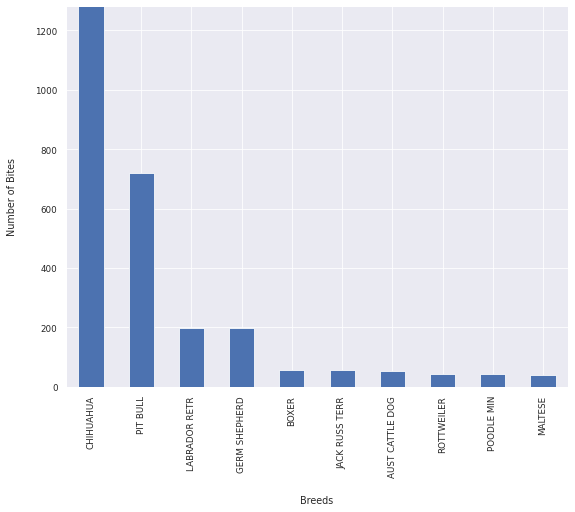

In [20]:
#breed_group = df_sf.breed_group
#print(breed_group.unique())
#primary_breed = df_sf.primary_breed
#print(primary_breed.unique().size)
#print(df_sf.head())
df_sf.info()
df_sf['breed_group'].value_counts().nlargest(10).plot(kind='bar')

plt.ylabel("Number of Bites")
plt.xlabel("Breeds")

This bar plot illustrates the number of bites by breed groups in the San Francisco Bite DataSet from 2014-2018.  As you can see, chihuahua passes pitbll by about ~500 bites.  Pit bull is second and surprisingly labrador retriever and german shepherd are tied for third.

# New York Bite Data 2015-2021

* Removed columns Borough, ZipCode, Species<br>
* Combined Gender and Spay/Neuter columns to match format of DF_SF gender column<br>
* Removed Key column and Date of bite column<br>
* Ages modified to standard values, removed alphas and turned numbers into decimal value in years.<br>
* Added Bad_Data column to tag potentially bad rows that could be thrown out of the dataset without tossing them out quite yet.<br>
* Added breed_group column to match df_sf dataset and clarify primary_breed values that specify a group.<br>
* Added Multi-Dog column for entries invloving more than one dog in description. Low numbers, may consider dropping these rows.<br><br>
* Standardized breed column and breed_group column.<br> 
* About 450 rows out of 22,000 were unable to be categorized, but contain dog descriptions so data was kept and categorized as "unknown".
<br><br>


---


* The data does not include whether one dog is a multi-offender, which may or may not be significant for our analysis.<br><br>
* This dataset can potentially be joined to the SF dataset on the breed_group	primary_breed	and	gender columns.<br><br>
* We may consider adding a bite_code column with code 1 for all entries. Since an entry here implies an incident it would match up to the existing column in the sf data.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22663 entries, 0 to 22662
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   breed_group    20445 non-null  object
 1   primary_breed  20445 non-null  object
 2   age            22663 non-null  object
 3   modified_age   22658 non-null  object
 4   gender         22663 non-null  object
 5   multi_dog      22663 non-null  object
 6   bad_data       22663 non-null  object
dtypes: object(7)
memory usage: 1.2+ MB
Mean of breed_group 160.98425196850394


Text(0.5, 0, 'Breeds')

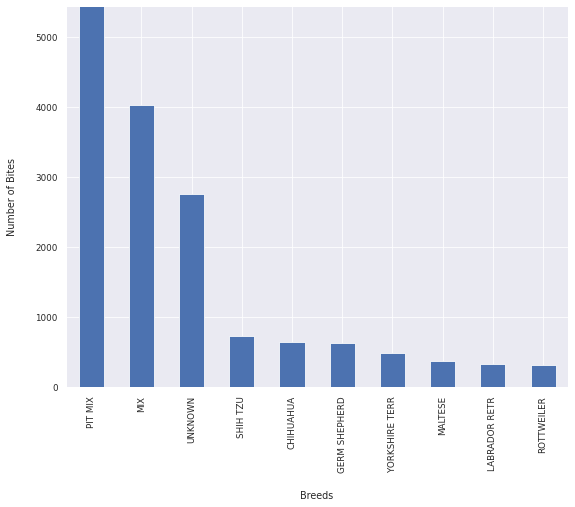

In [21]:
#print(df_ny.head())
df_ny.info()

mean_ny = df_ny["breed_group"].value_counts().mean()
print("Mean of breed_group", mean_ny)
df_ny['breed_group'].value_counts().nlargest(10).plot(kind='bar')
plt.ylabel("Number of Bites")
plt.xlabel("Breeds")

As you can tell our pit mix column is leading by more than 5000 bites and our mix followed by our unknown column.  Our shih tzu column is third and chihuahua is tied with german shepherd this time.  This is for the data in New York.

# Scaling Data Comparison using Normalization

In [22]:


normal_sf = np.array(df_sf['breed_group'].value_counts())
normal_ny = np.array(df_ny['breed_group'].value_counts())
print("San Francisco Breeds: ", normal_sf)
print("New York Breeds: ", normal_ny)
normal_sf1 = preprocessing.normalize([normal_sf])
normal_ny1 = preprocessing.normalize([normal_ny])

normF_sf1 = (normal_sf1*1000).astype(int)
normF_ny1 = (normal_ny1*1000).astype(int)
print("San Francisco Breeds Normalized: ", normF_sf1)
print("New York Breeds Normalized: ", normF_ny1)
#PROBLEM ( NORMALIZATION NUMBERS TOO SMALL TO PLOT so I multiplied by 10000)

#Convert normal to int 



San Francisco Breeds:  [1281  719  198  198   56   56   53   43   42   41   39   37   36   34
   32   30   30   29   24   23   23   21   21   18   18   17   15   14
   14   14   13   13   13   13   12   11   11   11   10   10    9    9
    9    8    8    8    8    8    8    7    7    7    7    7    7    7
    7    6    6    6    6    6    6    5    5    5    5    4    4    4
    4    4    4    4    4    3    3    3    3    3    3    3    3    3
    3    3    3    3    2    2    2    2    2    2    2    2    2    2
    2    2    2    2    2    2    2    2    2    2    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1]
New York Breeds:  [5437 4029 2762  732  648  625  488  374  325  316  306  303  264  195
  182  170  149  134  134  130  128  121  119  113  112   97   84   81
   78   74   72   69   65   64   64   63   61   54   51   49   47   44
   42   42   40   40   3

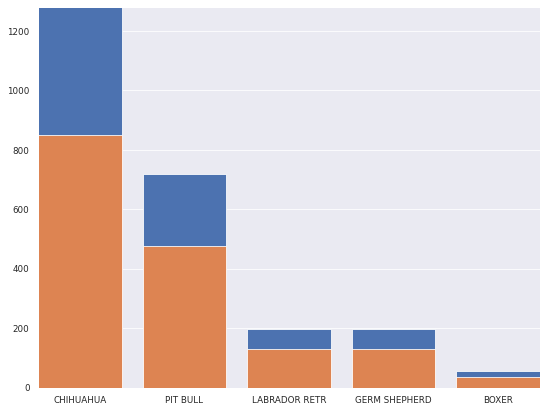

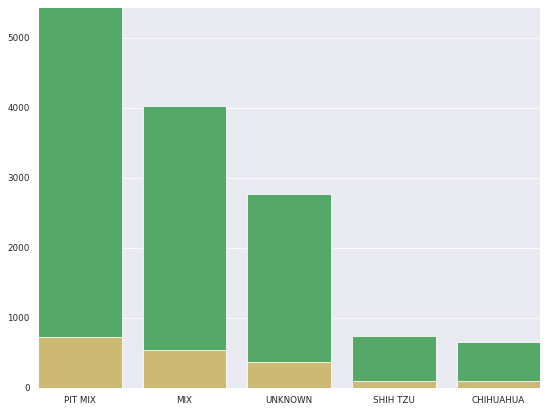

<BarContainer object of 5 artists>

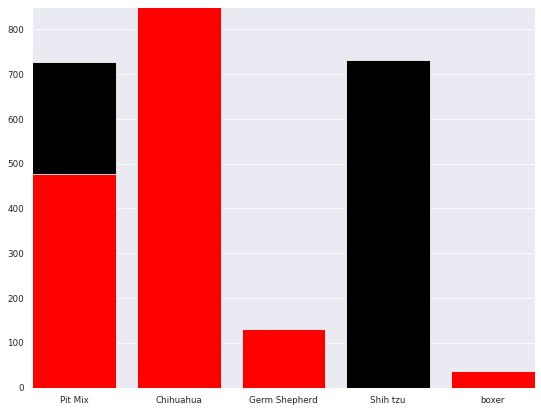

In [23]:

Xsf=['CHIHUAHUA', 'PIT BULL', 'LABRADOR RETR', 'GERM SHEPHERD', 'BOXER' ]
#X AXIS BREED NAME
Xny=['PIT MIX', 'MIX', 'UNKNOWN', 'SHIH TZU', 'CHIHUAHUA']
#Y AXIS BITE NUMBERS NORMALIZED AND NOT NORMALIZED COMPARISON
ysf=[1281, 719, 198, 198, 56]
ysfn=[850, 477, 131, 131, 37]
yny=[5437, 4029, 2762, 732, 648]
ynyn=[726, 538, 369, 97, 86]
#X2=[df_ny['breed_group']]
#X_axis1 = np.arrange(len(X1))
#X_axis2 = np.arrange(len(X2))
plt.bar(Xsf, ysf, label='San Fran')
plt.bar(Xsf, ysfn, label='San Fran Norm')


plt.show()

plt.bar(Xny, yny, label='New York', color='g')
plt.bar(Xny, ynyn, label='New York Norm', color='y')
plt.show()

#Combined Normalization Data
X3 = ['Pit Mix', 'Chihuahua', 'Germ Shepherd', 'Shih tzu', 'boxer']
ysfc=[477, 850, 131, 0, 37]
ynyc=[726, 86, 86, 732, 0]
plt.bar(X3, ynyc, label='Combined New York Normal Data', color='black')
plt.bar(X3, ysfc, label='Combined San Fran Normal Data', color='red')


With the scaled data, we can see that chihuahua has the largest data for the bites followed with a close tie with pit mix and shih tzu.

#How much data is there?

In [24]:
num_rows, num_cols = df_md.shape
print (num_rows, " Rows \n", num_cols, "Columns: ")
print(list(df_md.columns))
print("total number of NaN values in DF: ", df_md.isna().sum().sum())

na = df_md.isna().sum().sum()
#print(na)
total = df_md.count().sum().sum()
#print(total)
print("Percentage of NaN values in DF: ", ((na/total)*100).round(2),"%")
print("rows with NA: ", df_md.isna().any(axis=1).sum())
naRows = df_md.isna().any(axis=1).sum()
print("Percentage of rows containing NaN: ", ((naRows/total)*100).round(2),"%")
print("fraction of the column values that are NA values:\n", (df_md.isnull().sum() / len(df_md)*100).round(2))
df_md.info()

21911  Rows 
 12 Columns: 
['dataset', 'breed_group', 'breed_group_S', 'primary_breed', 'bite_code', 'bite_severity', 'gender', 'gender_S', 'age', 'average height', 'average_weight', 'lifespan']
total number of NaN values in DF:  25503
Percentage of NaN values in DF:  10.74 %
rows with NA:  19072
Percentage of rows containing NaN:  8.03 %
fraction of the column values that are NA values:
 dataset            0.00
breed_group        0.00
breed_group_S      0.00
primary_breed      0.00
bite_code          0.00
bite_severity     84.95
gender             0.00
gender_S          31.44
age                0.00
average height     0.00
average_weight     0.00
lifespan           0.00
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21911 entries, 0 to 21910
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dataset         21911 non-null  int64  
 1   breed_group     21911 non-null  int64  
 2   breed_group

We learn that most NaN values fall into two columns: **bite_severity** and **gender_S**. This is consistent with observations during merging and cleaning the data. We find the strings in these columns to be valuable for a subset of analysis that could be done on the smaller dataset. Since each row is representative of a bite event, that is more valuable for helping answer our question.<br>

While this does not quantify the data, it gives us some insight into some runtime metrics.<br>
From https://github.com/nschloe/perfplot:<br>
"perfplot extends Python's timeit by testing snippets with input parameters (e.g., the size of an array) and plotting the results."

In [25]:
#CODE from https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe
perfplot.save(
    "/usr/local/share/jupyter/nbextensions/out.png", transparent=False,
    setup=lambda n: pd.DataFrame(np.arange(n * 3).reshape(n, 3)),
    n_range=[2**k for k in range(25)],
    kernels=[
        lambda df_md: len(df_md.index),
        lambda df_md: df_md.shape[0],
        lambda df_md: df_md[df_md.columns[0]].count(),
    ],
    labels=["len(df_md.index)", "df_md.shape[0]", "df_md[df_md.columns[0]].count()"],
    xlabel="Number of rows",
)

Output()

In [26]:
%%html
<img src='/nbextensions/out.png' />

We get a breakdown of some of the mix details for primary_breed when breed_group is "MIX". I'd like to plot this to visualize the MIX breeds that are more frequently listed and if that correlates with the top 10 breeds in the following graph.

In [29]:
#Look at Unknown values. Unknowns include NaN converted to "U" signifier
nan_count = df_md.isna().sum().sum()
#print("Percent of Unknown age: ", (df_md['age']==0.sum() / len(df_md) *100).round(2))
#print("Percent of Unknown gender: ", (df_md['gender'].isna().sum().sum() / len(df_md) *100).round(2))
#print("Percent of Unknown breed_group: ", (df_md['breed_group'].isna().sum().sum() / len(df_md) *100).round(2))
#print("Percent of Unknown primary_breed: ", (df_md['primary_breed'].isna().sum().sum() / len(df_md) *100).round(2))
print("Percent of MIX breed in the dataset: ", (df_md['primary_breed'].str.contains('MIX', case=False, na=False).sum() / len(df_md) *100).round(2))
print("Percent of PIT BULL breed in the dataset: ", (df_md['primary_breed'].str.contains('PIT BULL', case=False, na=False).sum() / len(df_md) *100).round(2))
print("Percent of CHIHUAHUA breed in the dataset: ", (df_md['primary_breed'].str.contains('CHIHUAHUA', case=False, na=False).sum() / len(df_md) *100).round(2))
print("Mean age for all bite incidents: ", np.mean(df_md['age']).round(2))
print("Min age for all bite incidents: ", np.min(df_md['age']))
print("Max age for all bite incidents: ", np.max(df_md['age']))
#Look at MIX breeds and see if there is a correlation between top 10 breeds with bite incidents and mixes containing those breeds
print("MIX breed where primary_breed contains 'oodle': ", (df_md[df_md['primary_breed'].str.contains('oodle', case=False, na=False)]['breed_group_S'].str.contains('MIX', case=False)).sum())
print("MIX breed where primary_breed contains '/' (implies a mix or cross): ", (df_md[df_md['primary_breed'].str.contains('/', case=False, na=False)]['breed_group_S'].str.contains('MIX', case=False)).sum())
print("MIX breed where primary_breed contains 'Terrier': ", (df_md[df_md['primary_breed'].str.contains('terrier', case=False, na=False)]['breed_group_S'].str.contains('MIX', case=False)).sum())
print("MIX breed where primary_breed contains 'shih': ", (df_md[df_md['primary_breed'].str.contains('shih', case=False, na=False)]['breed_group_S'].str.contains('MIX', case=False)).sum())
print("MIX breed where primary_breed contains 'chi': ", (df_md[df_md['primary_breed'].str.contains('chi', case=False, na=False)]['breed_group_S'].str.contains('MIX', case=False)).sum())
print("MIX breed where primary_breed contains 'germ': ", (df_md[df_md['primary_breed'].str.contains('germ', case=False, na=False)]['breed_group_S'].str.contains('MIX', case=False)).sum())
print("MIX breed where primary_breed contains 'york': ", (df_md[df_md['primary_breed'].str.contains('york', case=False, na=False)]['breed_group_S'].str.contains('MIX', case=False)).sum())
print("MIX breed where primary_breed contains 'lab': ", (df_md[df_md['primary_breed'].str.contains('lab', case=False, na=False)]['breed_group_S'].str.contains('MIX', case=False)).sum())
print("MIX breed where primary_breed contains 'malt': ", (df_md[df_md['primary_breed'].str.contains('malt', case=False, na=False)]['breed_group_S'].str.contains('MIX', case=False)).sum())
print("MIX breed where primary_breed contains 'pit': ", (df_md[df_md['primary_breed'].str.contains('pit', case=False, na=False)]['breed_group_S'].str.contains('MIX', case=False)).sum())
print("MIX breed where primary_breed contains 'pom': ", (df_md[df_md['primary_breed'].str.contains('pom', case=False, na=False)]['breed_group_S'].str.contains('MIX', case=False)).sum())
#df_md.sample(n=10)

Percent of MIX breed in the dataset:  15.83
Percent of PIT BULL breed in the dataset:  27.64
Percent of CHIHUAHUA breed in the dataset:  9.81
Mean age for all bite incidents:  2.34
Min age for all bite incidents:  0.0
Max age for all bite incidents:  21.0
MIX breed where primary_breed contains 'oodle':  328
MIX breed where primary_breed contains '/' (implies a mix or cross):  1245
MIX breed where primary_breed contains 'Terrier':  263
MIX breed where primary_breed contains 'shih':  224
MIX breed where primary_breed contains 'chi':  229
MIX breed where primary_breed contains 'germ':  132
MIX breed where primary_breed contains 'york':  157
MIX breed where primary_breed contains 'lab':  346
MIX breed where primary_breed contains 'malt':  185
MIX breed where primary_breed contains 'pit':  31
MIX breed where primary_breed contains 'pom':  47


Here we get an idea of reported incidents by severity. While a later display will show a correlation between gender and bite severity, here we see that more severe incidents occur much less frequently than milder incidents like a nip or single bite.

<AxesSubplot:xlabel='breed_group_S', ylabel='bite_severity'>

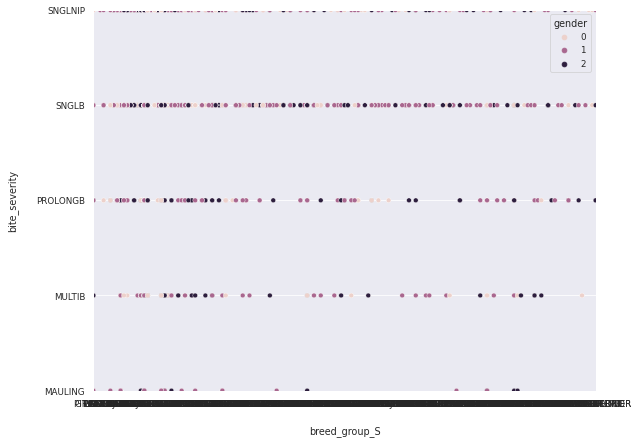

In [30]:
sns.scatterplot(x = 'breed_group_S', y = 'bite_severity', data=df_md, hue='gender')

Age of dogs by breed at the time of an incident. Typo outlier removed from dataset.

<AxesSubplot:xlabel='breed_group_S', ylabel='age'>

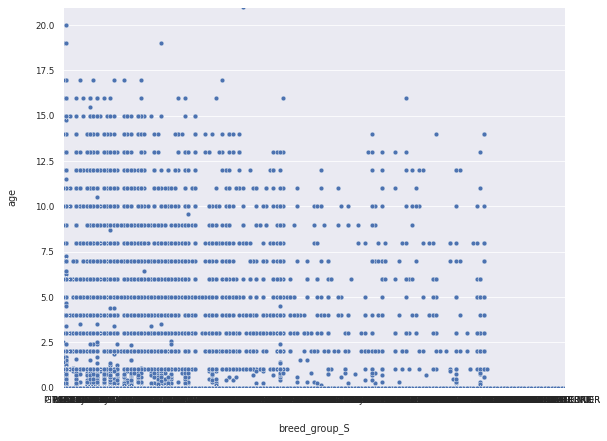

In [31]:
sns.scatterplot(x = 'breed_group_S', y = 'age', data=df_md)

Bite code by gender, we see overwhelmingly the most severe bite type occurs with neutered males. This is not consistent with perception and general biases.

Text(0.5, 1.0, 'Bite incident by gender')

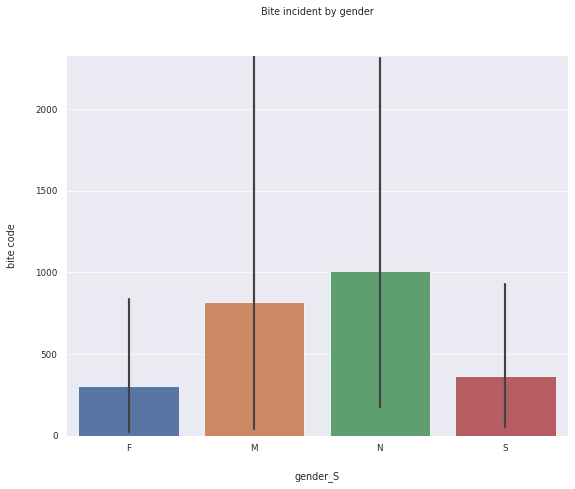

In [32]:
age_analysis = df_md.groupby(['gender_S', 'bite_code']).size().reset_index(name='bite code')
sns.barplot(x="gender_S", y="bite code", data=age_analysis).set_title("Bite incident by gender")

Top 10 breeds for all bite data in the dataset:

<AxesSubplot:>

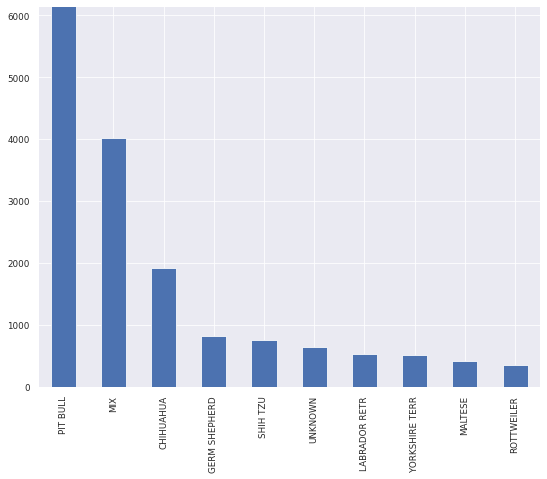

In [33]:
df_md['breed_group_S'].value_counts().nlargest(10).plot(kind='bar')

As you can see pitbull is the leading bite breed.

Average weights by breed

In [ ]:
plt.scatter(x = 'breed_group', y = 'average_weight', data=df_be, s=30)
plt.xlabel("Breeds")
plt.yticks(rotation=45)
plt.ylabel("Average Weight")

plt.show()

In [ ]:
sns.pairplot(df_md)
plt.show()

# Machine Learning

In [ ]:
#REMOVE THIS IF IT IS NOT USEFUL IT DOES NOT WORK AS-IS***
# From W7 lab 1
#Do you mean this lab?
#https://csumb.instructure.com/courses/19519/pages/lab-solutions-data-exploration-knn?module_item_id=1005002 
#or
#https://colab.research.google.com/drive/1_R-S7u-LrnUdATOVfopuBcLU-uJFgzoW?usp=sharing 

# use only numeric data, and scale it
df = df_final[['age']]
weight = df_final['average_weight']
X = df.apply(zscore).values
y = weight.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# see how knn classifier works as training size changes
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train[:10,:])

k = 3
knn = KNeighborsClassifier(n_neighbors=k)
te_errs = []
tr_errs = []
tr_sizes = np.linspace(100, X_train.shape[0], 10).astype(int)
for tr_size in tr_sizes:
  X_train1 = X_train[:tr_size,:]
  y_train1 = y_train[:tr_size]
  
  # train model on a subset of the training data
  knn.fit(X_train1, y_train1)

  # error on subset of training data
tr_predicted = knn.predict(X_train1)
err = (tr_predicted != y_train1).mean()
tr_errs.append(err)
  
  # error on all test data
te_predicted = knn.predict(X_test)
err = (te_predicted != y_test).mean()
te_errs.append(err)

#plt.plot(tr_sizes, te_errs, label = '')
#plt.plot(tr_sizes, tr_errs, label = '')
plt.legend()
#plt.title('')
plt.xlabel('age')
plt.ylabel('bite code')

In [ ]:
#ML using KNN
df_final.info()
df_final = df_final.dropna()

#Predict the likelihood of a bite incident occuring in a dog's life by breed
predictors =['age', 'gender', 'average_weight', 'average_height', 'average_lifespan']
#gender is an object (change to numbers)

#labeling encoder target is label 
target = 'breed_group'
X = df_final[predictors].values.astype(int) #ERROR TO DROP NA
y = (df_final[target]).values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

#Scale data

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

regr = KNeighborsRegressor()
regr.fit(X_train, y_train)

#make predictions
predictions = regr.predict(X_test)
print(predictions[:10].astype(int))
print(y_test[:10])

#Compute Mean Squared Error of Predictions
mse= ((predictions - y_test) ** 2).mean()
print('MSE: {0: .0f}'.format(mse))

#plot prediction error as histogram
plt.figure(figsize=(8,6))
sns.distplot(predictions - y_test, kde=False)
plt.title('Histogram of Prediction error')
plt.xlabel('Absolute difference between prediction and actual values')
plt.xlim(-12000, 12000);

#after this compare with linear regression



As we are looking for any linear relationship, we can tell that as the average height increases, the average weight increases too.  There is no data for age and bite_code yet.

We are going to start by using linear regression for the machine learning.

We are going to predict the likelihood of a bite incident occuring in a dog's lifetime based on size, breed, and age. 

We will compare this data by people's perception based on breed banning in different states.

# Conclusion

Our goal is to help people understand that all dogs need to be trained regardless of breed.  
We hope to give knowledge to everyone to help find the breeds that are suitable for them to prevent people from giving up their dogs.